In [1]:
#imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.signal as signal #signal processing stuff (e.g. filters, hilbert transform, etc.)
import scipy
import struct
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import svgutils.transform as sg
import sys

import nelpy as nel  # recommended import for nelpy
import nelpy.plotting as npl  # recommended import for the nelpy plotting library
import nelpy.io.trodes as neltro
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Cd Std', font_scale=2, palette=npl.colors.cows, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 20, 'xtick.labelsize': 20}))

from nelpy import EpochArray, AnalogSignalArray, SpikeTrainArray, BinnedSpikeTrainArray

from IPython.display import SVG, display, Image
#Set file name, threshold, other paramters that vary per data set
numTetrodes = 2 #I'm just assuming tetrodes that are gonna be used are 2,3,4 and channel 1 
                #since that's what I've been using....this isn't generic...This can only be set to 2 or 3.
recordingFilePath = "paperData/"
recordingFileName = "offlineAnalysis"
npzFileName = "offlineAnalysis"
blockLength = 0.200 #seconds to block after detection
multipleDetectionTimeRequirement = 0.015 #detecions must be within 15 ms of each other for us to stimulate
#Sampling rates
FS_system = 30000
FS = 3000 #decimated by 10
saveFigs = False

In [2]:
#for lfp
%matplotlib inline
mpl.rcdefaults()
sns.set(rc={'font.family': 'sans-serif','figure.figsize': (12, 4),'lines.linewidth': 1, 'font.size': 18, 'axes.labelsize': 16, 'axes.titlesize':18, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')

<div class="alert alert-info">
The disruption data presented in this figure was not collected in the Real-time Neural Engineering lab (Kemere lab) and will not be made public.
</div>

# Disruption

In [3]:
asa = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_stimulation_two_channel14_5_27.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [3,1],\
                      channel = [1,1], decimation_factor = 1,)
asa

<AnalogSignalArray at 0x7f5bb5d9d518: 2 signals> for a total of 1:21:996 minutes

In [4]:
asa.add_signal(asa[:,1].ydata - asa[:,0].ydata,label='LFP')

<AnalogSignalArray at 0x7f5bb5d9d518: 3 signals> for a total of 1:21:996 minutes

In [5]:
#eyeballing ripple epochs aka when online stimulation happens
ripple_epochs = nel.EpochArray([[148,150],[166,168],[171,173],[180,182],[194,196],[208,210],[214,216]])
#find out stimulation times
max_times = [rippleLFP.time[np.argmax(rippleLFP.ydata)] for rippleLFP in asa[:,2][ripple_epochs]]
max_times

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


[148.90537676381274,
 166.69111573375829,
 172.1851380682719,
 180.85683998747902,
 195.57289981177865,
 209.19195517649305,
 214.83864479830234]

In [6]:
#redo ripple epochs with 500 ms windows around stimulation pulse
windowsize = 0.5 #seconds
ripple_epochs = nel.EpochArray(np.squeeze(np.array(\
                                                   [np.asarray(max_times)-windowsize,\
                                                    np.asarray(max_times)+windowsize])\
                                         ).T)

In [7]:
#add LFP (1-400 Hz)
asa.add_signal(nel.filtering.bandpass_filter(asa[:,2],lowcut=1,highcut=400,numtaps=\
                                                 nel.filtering.approx_number_of_taps(asa.fs,15)))
#add ripple band filtered
asa.add_signal(nel.filtering.ripple_band_filter(asa[:,2],verbose=True))
#add ripple band power 
asa.add_signal(nel.utils.signal_envelope1D(asa[:,4],))

/home/shayok/Documents/Code/nelpy/nelpy/filtering.py:105: UserWarning: no sampling frequency provided, using fs=3000.0 Hz from AnalogSignalArray
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:404: UserWarning: None label appended
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:404: UserWarning: None label appended


Filtering with 100 taps.


/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:404: UserWarning: None label appended


<AnalogSignalArray at 0x7f5bb5d9d518: 6 signals> for a total of 1:21:996 minutes

In [8]:
windowsize = 0.055 #seconds
stim_artifacts = nel.EpochArray(np.squeeze(np.array(\
                                                   [np.asarray(max_times)-0.005,\
                                                    np.asarray(max_times)+windowsize])\
                                         ).T)

In [9]:
#remove stimulation epochs since they are just noise....
asa_stim_pulse_removed = asa[:,3][stim_artifacts.complement(asa.support)]
#add ripple band filtered
asa_stim_pulse_removed.add_signal(nel.filtering.ripple_band_filter(asa_stim_pulse_removed[:,0],verbose=True), label='Ripple Band Filtered')
#add power signal
asa_stim_pulse_removed.add_signal(nel.utils.signal_envelope1D(asa_stim_pulse_removed[:,1],),label='Ripple Band Power')

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


Filtering with 100 taps.


<AnalogSignalArray at 0x7f5bb5d9da58: 3 signals (8 segments)> for a total of 1:21:576 minutes

<AnalogSignalArray at 0x7f5bb5d66198: 1 signals> for a total of 1:21:996 minutes
<AnalogSignalArray at 0x7f5bb5d666d8: 1 signals> for a total of 200 milliseconds
<AnalogSignalArray at 0x7f5bb5d66d30: 1 signals> for a total of 140 milliseconds
<AnalogSignalArray at 0x7f5bb5d70e80: 1 signals> for a total of 200 milliseconds
<AnalogSignalArray at 0x7f5bb5d157b8: 1 signals> for a total of 140 milliseconds


/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


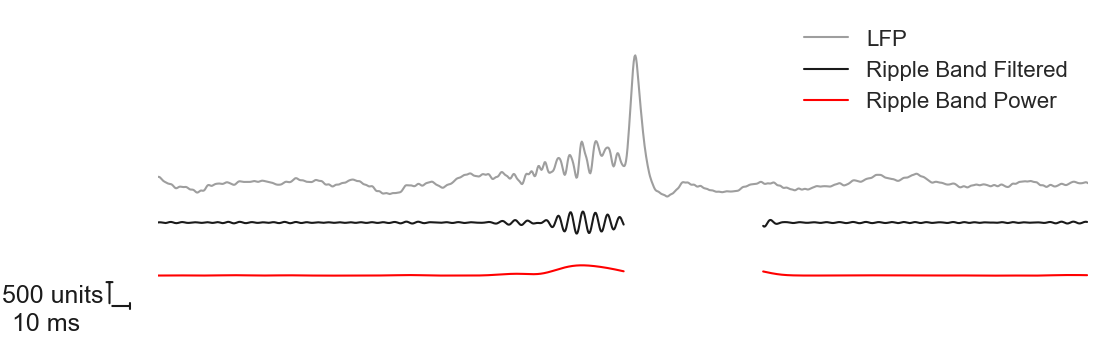

In [10]:
starttime = ripple_epochs.time[0][0]
endtime = ripple_epochs.time[0][1]

#LFP
npl.plot(asa[:,3]+1750,color='0.6',alpha=0.95,linewidth=1.5)

#ripple band power
ax = npl.plot(asa_stim_pulse_removed[:,1][nel.EpochArray([148.7,149.1])]+1000,color='k',linewidth=1.5)

#power signal
npl.plot(asa_stim_pulse_removed[:,-1][nel.EpochArray([148.7,149.1])],color="red",linewidth=1.5)

npl.utils.clear_left_right(ax)
npl.utils.clear_top_bottom(ax)

npl.scalebar.add_scalebar(ax=ax, sizex=0.01, sizey=500, labely='500 units', labelx='10 ms', pad=0, loc=3,bbox_to_anchor=(0,20))

ax.set_xlim(148.7,149.1)
# ax.set_ylim(-400,1000)
ax.legend(['LFP','Ripple Band Filtered','Ripple Band Power'],bbox_to_anchor=(1,1),loc=1,)
# plt.savefig("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_new/fig1/disruption.svg")
plt.show()

# Control Stimulation

In [11]:
real_time_signals = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_control_stimulation_single_channel1_5_27.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [4,3],\
                      channel = [1,3], trodes_style_decimation=True, trodes_lowpass_filter_freq=400,\
                      trodes_highpass_filter_freq=0, verbose = False)
real_time_signals

<AnalogSignalArray at 0x7f5bb5d9d710: 2 signals> for a total of 41.442 seconds

In [12]:
#subtract off reference and generate new analogsignal
real_time_signals.add_signal(real_time_signals.ydata[0]-real_time_signals.ydata[1],label="LFP")
real_time_signals.labels

array(['t4c1', 't3c3', 'LFP'], 
      dtype='<U4')

In [13]:
offline_analysis_signals = neltro.load_wideband_lfp_rec("/home/shayok/Documents/Code/RippleDetectionAnalysis/TingData/Kant_control_stimulation_single_channel1_5_27.rec",\
                      "/home/shayok/Documents/Code/trodes/", tetrode = [4,3],\
                      channel = [1,3], trodes_style_decimation=True, verbose = False)

In [14]:
#subtract off reference and generate new analogsignal
offline_analysis_signals.add_signal(offline_analysis_signals.ydata[0]-offline_analysis_signals.ydata[1],label="t4c1_refsubtracted")

<AnalogSignalArray at 0x7f5bc6eff898: 3 signals> for a total of 41.442 seconds

In [15]:
#add LFP (1-400 Hz)
offline_analysis_signals.add_signal(nel.filtering.bandpass_filter(offline_analysis_signals[:,2],lowcut=1,highcut=400,numtaps=\
                                                 nel.filtering.approx_number_of_taps(offline_analysis_signals.fs,15)),\
                                   label="LFP")

/home/shayok/Documents/Code/nelpy/nelpy/filtering.py:105: UserWarning: no sampling frequency provided, using fs=30000.0 Hz from AnalogSignalArray


<AnalogSignalArray at 0x7f5bc6eff898: 4 signals> for a total of 41.442 seconds

In [16]:
#offline analysis
# filter raw data in ripple band (150 - 250 Hz)
ripple_band_filtered_offline = nel.filtering.ripple_band_filter(offline_analysis_signals[:,-1], verbose=True)

# compute envelope of signal (Hilbert Transform)
envelope_offline = nel.utils.signal_envelope1D(ripple_band_filtered_offline,)

Filtering with 1000 taps.


In [17]:
envelope_offline

<AnalogSignalArray at 0x7f5bf42eec50: 1 signals> for a total of 41.442 seconds

In [18]:
np.where(offline_analysis_signals[:,-1][nel.EpochArray([118.5,118.9])].ydata.squeeze() == \
         np.max(offline_analysis_signals[:,-1][nel.EpochArray([118.5,118.9])].ydata.squeeze()))

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


(array([7897]),)

In [19]:
offline_analysis_signals[:,-1][nel.EpochArray([118.5,118.9])].time[7897]

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


118.76323333333333

In [20]:
removeStimArtifact = nel.EpochArray([offline_analysis_signals[:,-1][nel.EpochArray([118.5,118.9])].time[7897]-0.015,\
                                    118.8])

/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
/home/shayok/Documents/Code/nelpy/nelpy/core/_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


<AnalogSignalArray at 0x7f5bb5ca0128: 1 signals> for a total of 400 milliseconds
<AnalogSignalArray at 0x7f5bb5ca34e0: 1 signals> for a total of 228 milliseconds
<AnalogSignalArray at 0x7f5bb5ca0cc0: 1 signals> for a total of 120 milliseconds
<AnalogSignalArray at 0x7f5bb5cac630: 1 signals> for a total of 228 milliseconds
<AnalogSignalArray at 0x7f5bb5caceb8: 1 signals> for a total of 120 milliseconds


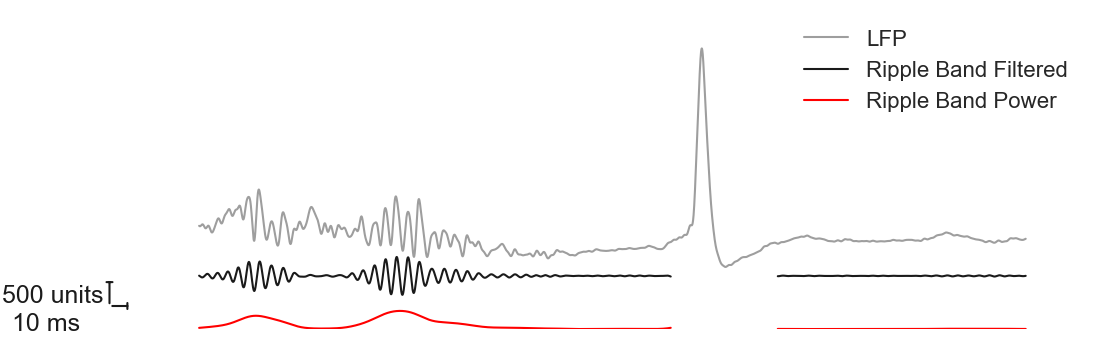

In [21]:
# starttime = ripple_epochs.time[0][0]
# endtime = ripple_epochs.time[0][1]

#LFP
npl.plot(offline_analysis_signals[:,-1][nel.EpochArray([118.52,118.92])]+1750,color='0.6',alpha=0.95,linewidth=1.5)

#ripple band power
ax = npl.plot(ripple_band_filtered_offline[nel.EpochArray([118.52,118.92])][removeStimArtifact.complement\
                                                                         (ripple_band_filtered_offline[nel.EpochArray([118.5,118.92])].support)]\
              +1000,color='k',linewidth=1.5)


#power signal
npl.plot(envelope_offline[nel.EpochArray([118.52,118.92])][removeStimArtifact.complement\
                                                                         (envelope_offline[nel.EpochArray([118.5,118.92])].support)],color="red",linewidth=1.5)

npl.utils.clear_left_right(ax)
npl.utils.clear_top_bottom(ax)

npl.scalebar.add_scalebar(ax=ax, sizex=0.01, sizey=500, labely='500 units', labelx='10 ms', pad=0, loc=3,bbox_to_anchor=(0,20))

# ax.set_xlim(148.7,149.1)
# ax.set_ylim(-400,1000)
ax.legend(['LFP','Ripple Band Filtered','Ripple Band Power'],bbox_to_anchor=(1,1),loc=1,)
# plt.savefig("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_new/fig1/control.svg")
plt.show()